# Covariance analysis

In [2]:
import numpy as np
import pandas as pd

import csv
import numpy as np
import pylab as plt
import scipy.spatial
from astropy.table import Table
import subprocess
import os, pdb
from datetime import datetime
from matplotlib import dates as mp_dates
from matplotlib import ticker
import glob
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
from pandas import read_csv
from astropy.modeling import fitting
from astropy.stats import sigma_clip
from astropy.table import Column, Table
import scipy.linalg
from matplotlib import cm
from astropy.stats import sigma_clipped_stats
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns

df_acov -  
ANA.acov.20220607.txt - aocbcovfname, UTdate, UTtime, det, vdir, vspd, sigma_vspd
* det = average detection of detections in the cluster
* vdir = direction in cartesian frame.  Do a vdir = (270-vdir) mod 360 to get it into deg E of N
* vspd = speed in meters/sec
* sigma_vspd = fractional std dev of the derived speeds for detections in the cluster

In [3]:
df_acov = pd.read_csv('ANA.acov.20220607.txt',sep="\s+",
        names = ['aocbcovfname', 'UTdate', 'UTtime', 'det', 'vdir', 'vspd', 'sigma_vsp'])
df_acov

,aocbcovfname,UTdate,UTtime,det,vdir,vspd,sigma_vsp
0,20180301_aocb0001_tmax200_stt.fits,20180301,60821,3.95,62.3,0.4,0.09
1,20180301_aocb0001_tmax200_stt.fits,20180301,60821,3.84,169.2,0.4,0.10
2,20180301_aocb0002_tmax200_stt.fits,20180301,60935,4.24,93.6,0.4,0.07
3,20180301_aocb0002_tmax200_stt.fits,20180301,60935,3.94,-26.1,0.4,0.08
4,20180301_aocb0003_tmax200_stt.fits,20180301,62013,5.69,-90.0,56.2,0.00
...,...,...,...,...,...,...,...
1969,20210503_aocb0047o_tmax200_stt.fits,20210503,145906,7.04,-106.6,3.7,0.63
1970,20210503_aocb0047o_tmax200_stt.fits,20210503,145906,4.66,69.0,9.0,0.78
1971,20210503_aocb0049o_tmax200_stt.fits,20210503,150648,5.54,-94.1,2.8,0.41
1972,20210503_aocb0052o_tmax200_stt.fits,20210503,151849,4.49,18.7,14.7,1.46


df_acov_GL - 
ANA.acov.20220607.GL.txt - aocbcovfname, GL?
* GL is a boolean - 0= not a GL; 1=ground layer (only in xcov)

In [4]:
df_acov_GL = pd.read_csv('ANA.acov.20220607.GL.txt',sep="\s+", 
                        names = ['aocbcovfname', 'GL?'])
df_acov_GL

,aocbcovfname,GL?
0,20180301_aocb0001_tmax200_stt.fits,1
1,20180301_aocb0001_tmax200_stt.fits,1
2,20180301_aocb0002_tmax200_stt.fits,1
3,20180301_aocb0002_tmax200_stt.fits,1
4,20180301_aocb0003_tmax200_stt.fits,1
...,...,...
1969,20210503_aocb0047o_tmax200_stt.fits,1
1970,20210503_aocb0047o_tmax200_stt.fits,1
1971,20210503_aocb0049o_tmax200_stt.fits,1
1972,20210503_aocb0052o_tmax200_stt.fits,1


df_acov_cfht - 
ANA.acov.20220607.cfht.txt - julian time (seconds), cfht_spd, cfht_dir
* julian time - I can convert this to UT date/UT time but its not needed since the files all "line" up
* cfht_spd: converted to m/s
* cfht_dir: angle in degrees E of N.
* spd and dir are the average of all CFHT measurements within +/- 5 min of the AOCB time

In [5]:
df_acov_cfht = pd.read_csv('ANA.acov.20220607.cfht.txt',sep="\s+", 
                          names = ['julian_t_s', 'cfht_spd', 'cfht_dir'])
df_acov_cfht

,julian_t_s,cfht_spd,cfht_dir
0,573199680.0,1.0802,110.6
1,573199680.0,1.0802,110.6
2,573199740.0,1.3374,110.9
3,573199740.0,1.3374,110.9
4,573200450.0,2.0062,103.4
...,...,...,...
1969,-99.0,-99.0000,-99.0
1970,-99.0,-99.0000,-99.0
1971,-99.0,-99.0000,-99.0
1972,-99.0,-99.0000,-99.0


df_acov_gfs - 
ANA.acov.20220607.gfs.txt - these are the 12UT GFS model predictions.  There is only one GFS value per night so this file has lots of repeated lines.  We could do somewhat better if we used the forecast in the model.  This would give us better resolution on the time (though not obviously better accuracy).
* julian time - see above for CFHT time
* then vspd[700mb, 650, 600, 550, 500, 450, 400, 350, 300, 250mb] - m/s
* and vdir[700mb, 650, 600, 550, 500, 450, 400, 350, 300, 250mb] - degrees E of N
* Note that the conversion from pressure to altitude (above sea level) is approximately:
; a=700mb, b=650, c=600, d=550, e=500, f=450, g=400, h=350, i=300, j=250mb
; h=3000m above sea level, 3590,  4200,  4860,  5580,  6300,  7200,  8100,  9170,  10400masl
* The summit is at about 600mb so if you plan to compare to the MASS altitudes (which are in meters above the summit) you'll need to convert these to height above Maunakea.

In [6]:
df_acov_gfs = pd.read_csv('ANA.acov.20220607.gfs.txt',sep="\s+",
                names = ['julian_t_s', 'vspd_700mb', 'vspd_650mb', 'vspd_600mb', 'vspd_550mb', 'vspd_500mb', 'vspd_450mb', 'vspd_400mb', 'vspd_350mb', 'vspd_300mb', 'vspd_250mb', 
                         'vdir_700mb', 'vdir_650mb', 'vdir_600mb', 'vdir_550mb', 'vdir_500mb', 'vdir_450mb', 'vdir_400mb', 'vdir_350mb', 'vdir_300mb', 'vdir_250mb'])
df_acov_gfs

,julian_t_s,vspd_700mb,vspd_650mb,vspd_600mb,vspd_550mb,vspd_500mb,vspd_450mb,vspd_400mb,vspd_350mb,vspd_300mb,...,vdir_700mb,vdir_650mb,vdir_600mb,vdir_550mb,vdir_500mb,vdir_450mb,vdir_400mb,vdir_350mb,vdir_300mb,vdir_250mb
0,573177600.0,8.1327,5.4063,5.3961,7.0781,9.0689,9.8971,10.6892,11.8415,12.0678,...,143.0,155.0,171.0,183.0,204.0,209.0,214.0,224.0,238.0,257.0
1,573177600.0,8.1327,5.4063,5.3961,7.0781,9.0689,9.8971,10.6892,11.8415,12.0678,...,143.0,155.0,171.0,183.0,204.0,209.0,214.0,224.0,238.0,257.0
2,573177600.0,8.1327,5.4063,5.3961,7.0781,9.0689,9.8971,10.6892,11.8415,12.0678,...,143.0,155.0,171.0,183.0,204.0,209.0,214.0,224.0,238.0,257.0
3,573177600.0,8.1327,5.4063,5.3961,7.0781,9.0689,9.8971,10.6892,11.8415,12.0678,...,143.0,155.0,171.0,183.0,204.0,209.0,214.0,224.0,238.0,257.0
4,573177600.0,8.1327,5.4063,5.3961,7.0781,9.0689,9.8971,10.6892,11.8415,12.0678,...,143.0,155.0,171.0,183.0,204.0,209.0,214.0,224.0,238.0,257.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,580780800.0,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1970,580780800.0,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1971,580780800.0,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1972,580780800.0,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,-99.0000,...,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


## Plots

In [21]:
%matplotlib inline

### 1. Plot the detection population

In [10]:
# datetime from date elements
df_acov['UTdatetime'] = df_acov['UTdate'].astype(str) + df_acov['UTtime'].astype(str).str.zfill(6)
df_acov['UTdatetime'] = pd.to_datetime(df_acov['UTdatetime'], format='%Y%m%d%H%M%S')

In [13]:
# append in the GL designation
# df_acov.join(df_acov_GL) #This didn't work

df_cov = pd.merge(df_acov, df_acov_GL, left_index=True, right_index=True)

[]

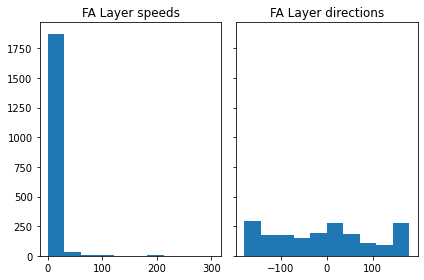

In [27]:
# Histogram of the population 

n_bins = 10
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(df_cov[df_cov['GL?'] == 1]['vspd'], bins=n_bins)
axs[1].hist(df_cov[df_cov['GL?'] == 1]['vdir'], bins=n_bins)

axs[0].set_title("FA Layer speeds")
axs[1].set_title("FA Layer directions")

plt.tight_layout()
plt.plot()

[]

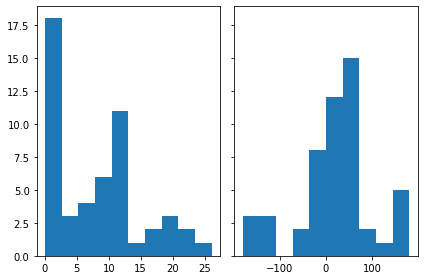

In [18]:
# Histogram of the population 
n_bins = 10
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(df_cov[df_cov['GL?'] == 0]['vspd'], bins=n_bins)
axs[1].hist(df_cov[df_cov['GL?'] == 0]['vdir'], bins=n_bins)


plt.plot()

### 2. Compare to CFHT

### 3. Compare to GFS

#### 3.1 Compare to 250mb

#### 3.2 Closest GFS mb

### 4. Compare to MASS